In [1]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

In [3]:
# Load the training and testing data
train_path = '/content/Google_train_data.csv'
test_path = '/content/Google_test_data.csv'
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

In [4]:
# Debugging: Check the data types of the columns
print("Training data types:\n", train_data.dtypes)
print("Testing data types:\n", test_data.dtypes)

Training data types:
 Date       object
Open      float64
High      float64
Low       float64
Close      object
Volume     object
dtype: object
Testing data types:
 Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [5]:
# Preprocess the data
def preprocess_data(data):
    # Check and convert the 'Volume' and 'Close' columns to strings if they are not already
    if data['Volume'].dtype != 'object':
        data['Volume'] = data['Volume'].astype(str)
    if data['Close'].dtype != 'object':
        data['Close'] = data['Close'].astype(str)

    # Remove commas and convert to float
    data['Volume'] = data['Volume'].str.replace(',', '').astype(float)
    data['Close'] = data['Close'].str.replace(',', '').astype(float)
    data = data.drop(columns=['Date'])

    # Feature Engineering: Add moving averages
    data['SMA_10'] = data['Close'].rolling(window=10).mean()
    data['SMA_50'] = data['Close'].rolling(window=50).mean()

    # Feature Engineering: Add more technical indicators
    data['EMA_10'] = data['Close'].ewm(span=10, adjust=False).mean()
    data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
    data['Price_Range'] = data['High'] - data['Low']
    data['Price_Change'] = data['Close'] - data['Open']
    data['Rolling_STD_10'] = data['Close'].rolling(window=10).std()
    data['Rolling_STD_50'] = data['Close'].rolling(window=50).std()

    # Fill NaN values that were introduced by rolling
    data = data.fillna(0)

    return data

In [6]:
# Apply preprocessing to the data
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

In [7]:
# Verify preprocessing
print("Processed training data:\n", train_data.head())
print("Processed testing data:\n", test_data.head())

Processed training data:
      Open    High     Low   Close      Volume  SMA_10  SMA_50      EMA_10  \
0  325.25  332.83  324.97  663.59   7380500.0     0.0     0.0  663.590000   
1  331.27  333.87  329.08  666.45   5749400.0     0.0     0.0  664.110000   
2  329.83  330.75  326.89  657.21   6590300.0     0.0     0.0  662.855455   
3  328.34  328.77  323.68  648.24   5405900.0     0.0     0.0  660.198099   
4  322.04  322.29  309.46  620.76  11688800.0     0.0     0.0  653.027536   

       EMA_50  Price_Range  Price_Change  Rolling_STD_10  Rolling_STD_50  
0  663.590000         7.86        338.34             0.0             0.0  
1  663.702157         4.79        335.18             0.0             0.0  
2  663.447562         3.86        327.38             0.0             0.0  
3  662.851187         5.09        319.90             0.0             0.0  
4  661.200553        12.83        298.72             0.0             0.0  
Processed testing data:
           Open         High         

In [8]:
# Separate features and target variable in training data
X_train = train_data.drop(columns=['Close'])
y_train = train_data['Close']

In [9]:
# Separate features and target variable in testing data
X_test = test_data.drop(columns=['Close', 'Adj Close'])
y_test = test_data['Close']

In [10]:
# Split training data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [11]:
# Define the CatBoost model with hyperparameter tuning
model = CatBoostRegressor(loss_function='RMSE', logging_level='Silent')

param_grid = {
    'iterations': [500, 1000, 1500],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train_split, y_train_split)

Fitting 3 folds for each of 180 candidates, totalling 540 fits


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7d8058bd82b0>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 8, 10],
                         'iterations': [500, 1000, 1500],
                         'l2_leaf_reg': [1, 3, 5, 7, 9],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring='neg_mean_squared_error', verbose=2)

In [12]:
# Best model from grid search
best_model = grid_search.best_estimator_

In [13]:
# Evaluate model performance
y_pred = best_model.predict(X_test)

In [14]:
# Calculate custom accuracy
def custom_accuracy(y_true, y_pred):
    return np.mean(1 - np.abs((y_true - y_pred) / y_true))

accuracy = custom_accuracy(y_test.values, y_pred)
print(f'Custom Accuracy: {accuracy:.4f}')

Custom Accuracy: 0.6819


In [15]:
# Evaluate using standard metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

Mean Absolute Error (MAE): 362.78
Mean Squared Error (MSE): 136530.45
Root Mean Squared Error (RMSE): 369.50


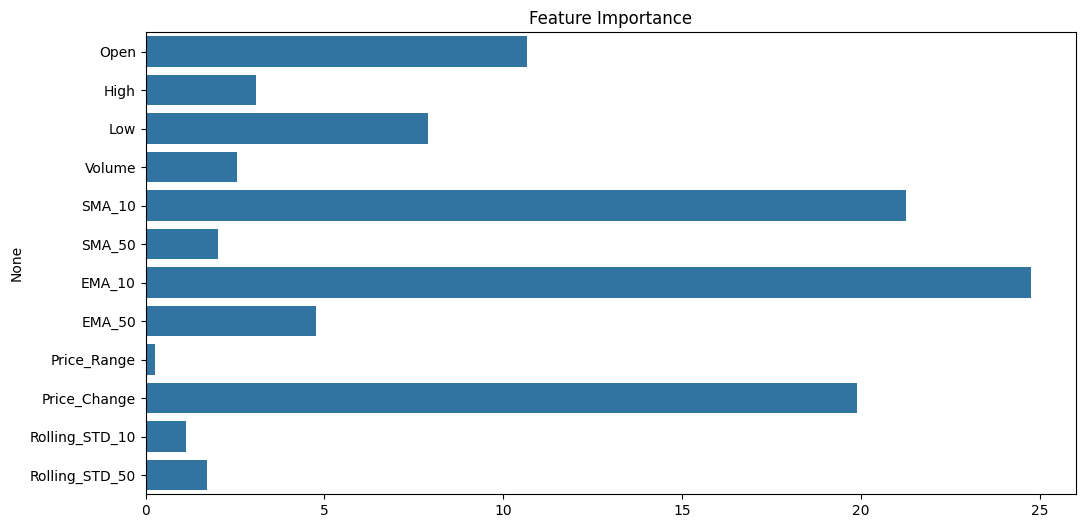

In [16]:
# Plot feature importance (optional)
feature_importances = best_model.get_feature_importance()
features = X_train.columns
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importances, y=features)
plt.title('Feature Importance')
plt.show()

In [17]:
# Function to make predictions with new input data
def predict_new(input_data):
    input_df = pd.DataFrame(input_data, index=[0])
    prediction = best_model.predict(input_df)
    return prediction[0]

In [18]:
# Example input data
new_input = {
    'Open': 1500,
    'High': 1520,
    'Low': 1480,
    'Volume': 1200000,
    'SMA_10': 1510,  # Example values for new features
    'SMA_50': 1490,  # Example values for new features
    'EMA_10': 1505,  # Example values for new features
    'EMA_50': 1485,  # Example values for new features
    'Price_Range': 40,  # Example values for new features
    'Price_Change': 20,  # Example values for new features
    'Rolling_STD_10': 5,  # Example values for new features
    'Rolling_STD_50': 10  # Example values for new features
}

# Make a prediction with the new input data
predicted_close = predict_new(new_input)
print(f'Predicted Close Price: {predicted_close:.2f}')

Predicted Close Price: 769.62
